## Load Wine Quality Dataset

In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 


## Exploratory Data Analysis

In [2]:
# Check variable information to understand the dataset
wine_quality.variables

,name,role,type,demographic,description,units,missing_values
0,fixed_acidity,Feature,Continuous,None,None,None,no
1,volatile_acidity,Feature,Continuous,None,None,None,no
2,citric_acid,Feature,Continuous,None,None,None,no
3,residual_sugar,Feature,Continuous,None,None,None,no
4,chlorides,Feature,Continuous,None,None,None,no
5,free_sulfur_dioxide,Feature,Continuous,None,None,None,no
6,total_sulfur_dioxide,Feature,Continuous,None,None,None,no
7,density,Feature,Continuous,None,None,None,no
8,pH,Feature,Continuous,None,None,None,no
9,sulphates,Feature,Continuous,None,None,None,no


In [3]:
X.shape

(6497, 11)

### Findings

In [4]:
# Check class distribution
y.value_counts(normalize=True)

quality
6          0.436509
5          0.329075
7          0.166077
4          0.033246
8          0.029706
3          0.004618
9          0.000770
Name: proportion, dtype: float64

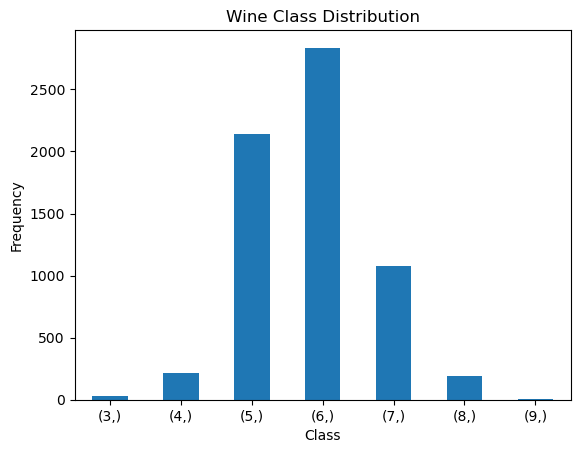

In [5]:
# Plot the class distribution based on y (labels)
import matplotlib.pyplot as plt

y.value_counts().sort_index().plot(kind='bar')
plt.title('Wine Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


### Insights

The above shows severe class imbalance and this will impact model performance significantly. 
- Two quality classes dominate. With quality 6 wines representing 43.7% of the dataset and quality 5 wines at 32.9%, they will lead to bias toward predicting these two most common classes. 
- Meanwhile, some quality classes are severely underrepresented, e.g. quality 3 at 0.5% and quality 9 at 0.08%, and this makes it nearly impossible for models to learn meaningful patterns for these edge cases. 

The imbalance will result in misleadingly high overall accuracy but poor performance on minority classes. If only use the current dataset for model training, biased predictions can be expected. 

To address this, following techniques will be used  
- SMOTE for oversampling, 
- class weighting, 
- or consider grouping quality scores into broader categories to create a more balanced learning environment. 
- Ensemble of combining multiple prediction models. 


## Model Investigation & Comparison

Given the class imbalance challenge, let's investigate which models perform best for wine quality prediction.    
We'll compare multiple approaches:

1. **Traditional Models**: Logistic Regression, Random Forest, SVM
2. **Ensemble Methods**: XGBoost, LightGBM (known for handling imbalanced data)
3. **Class Balancing**: Apply SMOTE and class weighting

**Evaluation**: 
- **Macro F1-Score**: 
    - formula: F1_macro = (1 / C) * Σ (F1_i)   for i = 1 ... C
        - C = number of classes  
        - F1_i = F1 score of class i
    - Average F1 across all classes, and number of samples in a class does not matter in this calculation.  
    This is a good measure for imbalanced data

- **Weighted F1-Score**: 
    - formula: F1_weighted = (1 / N) * Σ (n_i * F1_i)   for i = 1 ... C
        - n_i = number of samples in class i
        - N = total number of samples (sum of all n_i)
        - F1_i = F1 score of class i
    - F1 weighted by class frequency. Classes of larger samples dominate the final score
- **Per-class Performance**: Precision/Recall for each quality level
- **Confusion Matrix**: Visual representation of predictions vs actual

In [6]:
# Import required libraries for model comparison
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_auc_score
import warnings

# Ignore un-critical warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Convert target to 1D array since some models expect this format
y_flat = y.values.ravel()

# Check for missing values
print(f"Missing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in target: {y.isnull().sum().sum()}")

Missing values in features: 0
Missing values in target: 0


### Important Note: Label Encoding Requirements

**Which algorithms require 0-based encoding?**
- **XGBoost**: Requires explicit 0-based consecutive labels [0,1,2,3,4,5,6] 
- **Scikit-learn models** (LR, RF, SVM): Handle non-0-based labels automatically 
- **LightGBM**: Handles arbitrary labels like scikit-learn (no encoding needed) 

**Our wine qualities [3,4,5,6,7,8,9]:**
- Work fine with scikit-learn and LightGBM
- Break XGBoost (requires encoding)

**Implementation approach:**
- **XGBoost**: Encode labels → train → inverse transform predictions
- **LightGBM & scikit-learn**: Use original labels directly

### Split data to train and test, and prepare reverse-frequency weighting to compensate imbalance classes

In [7]:
# Split the data with stratification to maintain class distribution: 80% train and 20% test
# set random seed as 42 as a convention for reproducibility 
# and also because the answer to the ultimate question of life, the universe, and everything
X_train, X_test, y_train, y_test = train_test_split(
    X, y_flat, test_size=0.2, random_state=42, stratify=y_flat
)

# Validate the shape of the training and test sets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# Display y train, test, original distributions to validate stratification
distribution_df = pd.DataFrame({
    'Original': pd.Series(y_flat).value_counts(normalize=True).sort_index(),
    'Training': pd.Series(y_train).value_counts(normalize=True).sort_index(),
    'Test': pd.Series(y_test).value_counts(normalize=True).sort_index()
}).fillna(0)
display(distribution_df)

# Calculate class weights for imbalanced learning. Basically a reverse-frequency weighting
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
# Create a dictionary for class weights to map class labels to their corresponding weights
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
display(f"Class weights: {class_weight_dict}")

Training set shape: (5197, 11)
Test set shape: (1300, 11)


,Original,Training,Test
3,0.004618,0.004618,0.004615
4,0.033246,0.033288,0.033077
5,0.329075,0.329036,0.329231
6,0.436509,0.436598,0.436154
7,0.166077,0.166057,0.166154
8,0.029706,0.029632,0.030000
9,0.000770,0.000770,0.000769


'Class weights: {3: 30.93452380952381, 4: 4.291494632535095, 5: 0.4341687552213868, 6: 0.32720518793678777, 7: 0.8602880317828174, 8: 4.820964749536178, 9: 185.60714285714286}'

### Create `evaluate_model()` for Optimal Metrics for Wine Quality Dataset

The `evaluate_model()` function is designed to cater for the wine quality dataset and provides robust evaluation metrics. 

#### **1. Class Imbalance Problem in Wine Quality Data**
Our dataset exhibits severe class imbalance:
- **Quality 6**: 43.7% (dominant class)
- **Quality 5**: 32.9% (major class)  
- **Quality 7**: 16.6% (moderate)
- **Quality 4**: 3.3% (minority)
- **Quality 8**: 3.0% (minority)
- **Quality 3**: 0.5% (extreme minority)
- **Quality 9**: 0.08% (extremely rare)

This imbalance makes traditional accuracy misleading - a model could completely fail on predicting minority classes and only predicting class 5 & 6 perfect would achieve ~76% accuracy.

#### **2. Macro F1-Score: The Primary Metric**
```python
macro_f1 = f1_score(y_test, y_pred, average='macro')
```

**Why Macro F1 is ideal for this dataset:**
- **Equal class importance**: Treats each quality level as equally important (crucial for wine grading)
- **Minority class sensitive**: Poor performance on rare qualities (3, 8, 9) thru macro F1 metrics will significantly impact the score
- **Business relevance**: In wine quality, correctly identifying exceptional (9) and poor (3) wines is as important as common grades
- **Formula**: `F1_macro = (1/C) * Σ(F1_i)` where C=7 classes. Equal weight given to each quality level

#### **3. Weighted F1-Score: Complementary Context**
```python
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
```

**Purpose in evaluation:**
- **Sample-proportional weighting**: Reflects real-world class distribution 
- **Practical performance**: Shows how well the model performs on the major classes of wines    
- **Comparison baseline**: Helps identify if improvements in macro F1 come at the cost of overall performance   

#### **4. Cross-Validation with StratifiedKFold**
```python
cv_scores = cross_val_score(model, X_train, y_train, 
                           cv=StratifiedKFold(n_splits=5), scoring='f1_macro')
```

**Critical for this dataset because:**  
- **Maintains class distribution**: Each fold preserves the 43.7%/32.9%/16.6%/... ratio
- **Robust evaluation**: 5-fold CV provides reliability estimates, crucial given small minority classes
- **Variance assessment**: Standard deviation indicates model stability across different data splits
- **Prevents overfitting**: Especially important with only 30 samples of class 3 and 5 samples of class 9

#### **5. Detailed Classification Report**
```python
print(classification_report(y_test, y_pred))
```

**Provides granular insights:**
- **Per-class precision/recall**: Essential for understanding minority class performance
- **Support information**: Shows actual sample counts for each quality level in test set
- **F1-score breakdown**: Identifies which quality levels are problematic

#### **6. Why This Approach Outperforms Alternatives**

- **Simple Accuracy**: Would be misleading (76% by predicting only majority classes)
- **Micro F1**: Dominated by majority classes (equivalent to accuracy for multi-class)
- **Single train-test split**: Unreliable with small minority classes
- **AUC-ROC**: Complex for 7-class imbalanced problem, less interpretable

***Our approach***: Macro F1 + Cross-validation + Stratification = Reliable, interpretable, business-relevant evaluation

#### **7. Real-World Relevance**

In wine production and sales:
- **Quality 3 wines**: Must be identified to prevent brand damage
- **Quality 9 wines**: Premium pricing depends on accurate identification  
- **Balanced evaluation**: Equal importance to all quality levels aligns with wine industry standards

The `evaluate_model()` function thus provides a comprehensive, robust, and industry-relevant evaluation framework perfectly suited for the wine quality prediction challenge.

In [8]:
# Function to evaluate models and return comprehensive metrics
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, n_splits=5, random_state=42):
    """
    Evaluate a model and return performance metrics
    """
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')

    # Cross-validation for more robust evaluation.
    # K fold is 5 meaning 5 different train-test splits and each split is 80% train, 20% test
    cv_scores = cross_val_score(
        model, X_train, y_train, 
        cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state),
        scoring='f1_macro'
    )
    
    results = {
        'Model': model_name,
        'Macro F1': macro_f1,
        'Weighted F1': weighted_f1,
        'CV Mean F1': cv_scores.mean(),
        'CV Std F1': cv_scores.std(),
        'Predictions': y_pred
    }
    
    print(f"\n{model_name} Results:")
    print(f"Test Macro F1: {macro_f1:.4f}")
    print(f"Test Weighted F1: {weighted_f1:.4f}")
    print(f"CV Macro F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return results

### test baseline models without addressing class imbalance

In [9]:
print("=== BASELINE MODELS (No Imbalance Handling) ===")

# Initialize scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Logistic Regression (baseline)
lr_baseline = LogisticRegression(random_state=42, max_iter=1000)
lr_results = evaluate_model(lr_baseline, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression")

# 2. Random Forest (baseline)
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42)
rf_results = evaluate_model(rf_baseline, X_train, X_test, y_train, y_test, "Random Forest")

# 3. SVM (baseline)
svm_baseline = SVC(random_state=42)
svm_results = evaluate_model(svm_baseline, X_train_scaled, X_test_scaled, y_train, y_test, "SVM")

# Store baseline results
baseline_results = [lr_results, rf_results, svm_results]

=== BASELINE MODELS (No Imbalance Handling) ===

Logistic Regression Results:
Test Macro F1: 0.2237
Test Weighted F1: 0.5062
CV Macro F1: 0.2293 ± 0.0186

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       1.00      0.02      0.05        43
           5       0.58      0.54      0.56       428
           6       0.51      0.71      0.60       567
           7       0.52      0.28      0.37       216
           8       0.00      0.00      0.00        39
           9       0.00      0.00      0.00         1

    accuracy                           0.53      1300
   macro avg       0.37      0.22      0.22      1300
weighted avg       0.53      0.53      0.51      1300


Logistic Regression Results:
Test Macro F1: 0.2237
Test Weighted F1: 0.5062
CV Macro F1: 0.2293 ± 0.0186

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0

### Same baseline models but with class balancing

In [10]:
# Now test models with class balancing techniques
print("=== BASELINE MODELS WITH CLASS WEIGHTING ===")

# 1. Logistic Regression with class weights
lr_weighted = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_weighted_results = evaluate_model(lr_weighted, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression (Weighted)")

# 2. Random Forest with class weights
rf_weighted = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_weighted_results = evaluate_model(rf_weighted, X_train, X_test, y_train, y_test, "Random Forest (Weighted)")

# 3. SVM with class weights
svm_weighted = SVC(random_state=42, class_weight='balanced')
svm_weighted_results = evaluate_model(svm_weighted, X_train_scaled, X_test_scaled, y_train, y_test, "SVM (Weighted)")

# Store weighted results
weighted_results = [lr_weighted_results, rf_weighted_results, svm_weighted_results]

=== BASELINE MODELS WITH CLASS WEIGHTING ===

Logistic Regression (Weighted) Results:
Test Macro F1: 0.1978
Test Weighted F1: 0.3487
CV Macro F1: 0.2059 ± 0.0127

Classification Report:
              precision    recall  f1-score   support

           3       0.02      0.50      0.04         6
           4       0.10      0.47      0.16        43
           5       0.58      0.33      0.42       428
           6       0.57      0.26      0.35       567
           7       0.29      0.27      0.28       216
           8       0.08      0.46      0.13        39
           9       0.00      0.00      0.00         1

    accuracy                           0.30      1300
   macro avg       0.23      0.33      0.20      1300
weighted avg       0.49      0.30      0.35      1300


Logistic Regression (Weighted) Results:
Test Macro F1: 0.1978
Test Weighted F1: 0.3487
CV Macro F1: 0.2059 ± 0.0127

Classification Report:
              precision    recall  f1-score   support

           3       0.

### Compare baseline models vs class-weighted models

Baseline vs Class Weighted Model Performance:


,Model,Type,Macro F1,Weighted F1,CV Mean F1,CV Std F1
0,Logistic Regression,Baseline,0.2237,0.5062,0.2293,0.0186
1,Random Forest,Baseline,0.4057,0.6819,0.3727,0.0247
2,SVM,Baseline,0.2292,0.5380,0.2298,0.0085
3,Logistic Regression (Weighted),Class Weighted,0.1978,0.3487,0.2059,0.0127
4,Random Forest (Weighted),Class Weighted,0.3866,0.6696,0.3787,0.0177
5,SVM (Weighted),Class Weighted,0.2571,0.4281,0.2744,0.0166


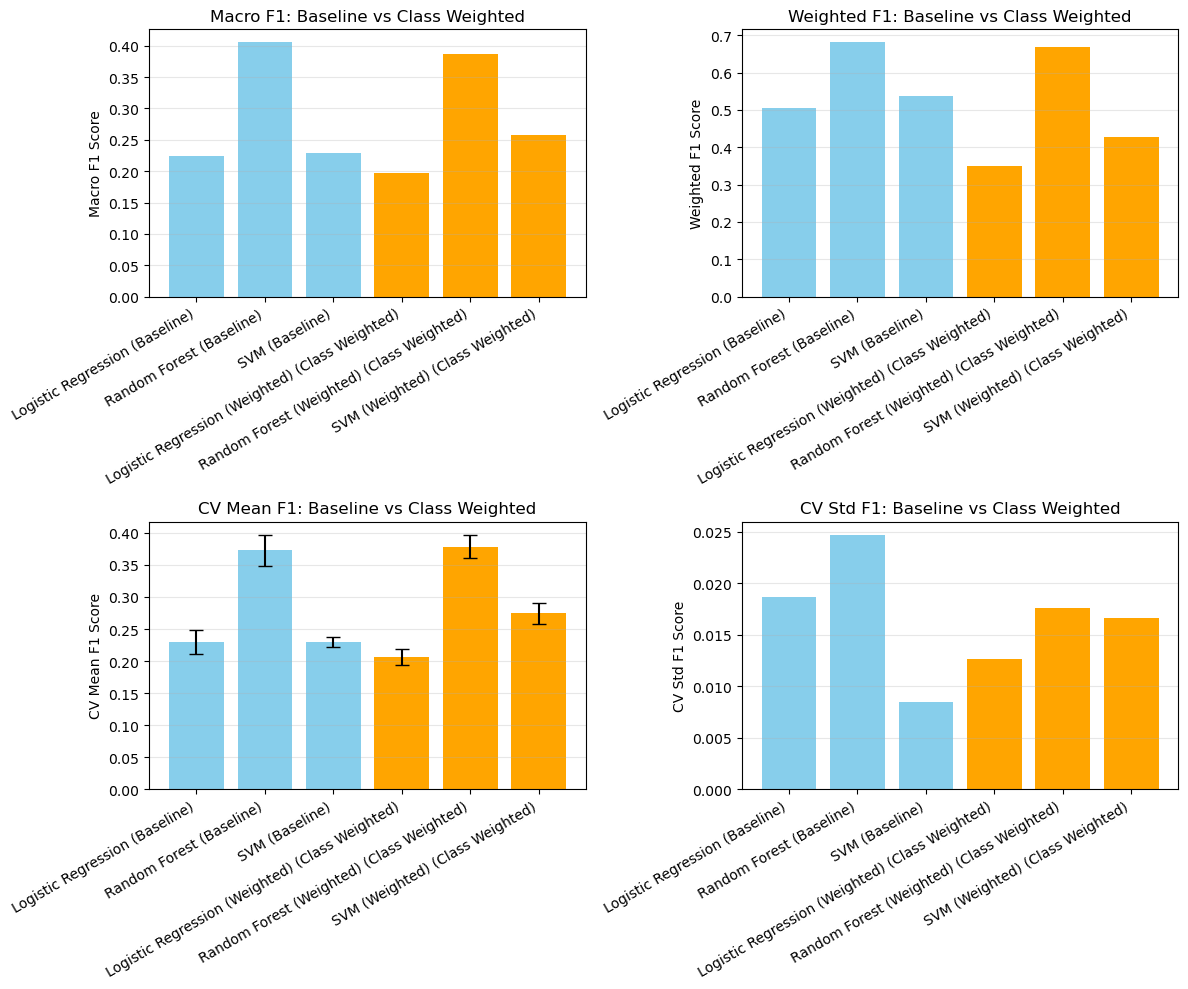

In [11]:
# Extract Macro F1 and Weighted F1 for each model
baseline_names = [res['Model'] for res in baseline_results]
baseline_macro_f1 = [res['Macro F1'] for res in baseline_results]
baseline_weighted_f1 = [res['Weighted F1'] for res in baseline_results]
baseline_cv_mean_f1 = [res['CV Mean F1'] for res in baseline_results]
baseline_cv_std_f1 = [res['CV Std F1'] for res in baseline_results]

weighted_names = [res['Model'] for res in weighted_results]
weighted_macro_f1 = [res['Macro F1'] for res in weighted_results]
weighted_weighted_f1 = [res['Weighted F1'] for res in weighted_results]
weighted_cv_mean_f1 = [res['CV Mean F1'] for res in weighted_results]
weighted_cv_std_f1 = [res['CV Std F1'] for res in weighted_results]

# Create comparison DataFrame
compare_df = pd.DataFrame({
    'Model': baseline_names + weighted_names,
    'Type': ['Baseline']*3 + ['Class Weighted']*3,
    'Macro F1': baseline_macro_f1 + weighted_macro_f1,
    'Weighted F1': baseline_weighted_f1 + weighted_weighted_f1,
    'CV Mean F1': baseline_cv_mean_f1 + weighted_cv_mean_f1,
    'CV Std F1': baseline_cv_std_f1 + weighted_cv_std_f1
})

print("Baseline vs Class Weighted Model Performance:")
display(compare_df.round(4))

### Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Macro F1 comparison
axes[0, 0].bar(compare_df['Model'] + " (" + compare_df['Type'] + ")", compare_df['Macro F1'], color=['skyblue']*3 + ['orange']*3)
axes[0, 0].set_ylabel('Macro F1 Score')
axes[0, 0].set_title('Macro F1: Baseline vs Class Weighted')
axes[0, 0].set_xticklabels(compare_df['Model'] + " (" + compare_df['Type'] + ")", rotation=30, ha='right')
axes[0, 0].grid(axis='y', alpha=0.3)

# Weighted F1 comparison
axes[0, 1].bar(compare_df['Model'] + " (" + compare_df['Type'] + ")", compare_df['Weighted F1'], color=['skyblue']*3 + ['orange']*3)
axes[0, 1].set_ylabel('Weighted F1 Score')
axes[0, 1].set_title('Weighted F1: Baseline vs Class Weighted')
axes[0, 1].set_xticklabels(compare_df['Model'] + " (" + compare_df['Type'] + ")", rotation=30, ha='right')
axes[0, 1].grid(axis='y', alpha=0.3)

# CV Mean F1 comparison
axes[1, 0].bar(compare_df['Model'] + " (" + compare_df['Type'] + ")", compare_df['CV Mean F1'], color=['skyblue']*3 + ['orange']*3)
axes[1, 0].set_ylabel('CV Mean F1 Score')
axes[1, 0].set_title('CV Mean F1: Baseline vs Class Weighted')
axes[1, 0].set_xticklabels(compare_df['Model'] + " (" + compare_df['Type'] + ")", rotation=30, ha='right')
axes[1, 0].grid(axis='y', alpha=0.3)

# CV Std F1 comparison
axes[1, 1].bar(compare_df['Model'] + " (" + compare_df['Type'] + ")", compare_df['CV Std F1'], color=['skyblue']*3 + ['orange']*3)
axes[1, 1].set_ylabel('CV Std F1 Score')
axes[1, 1].set_title('CV Std F1: Baseline vs Class Weighted')
axes[1, 1].set_xticklabels(compare_df['Model'] + " (" + compare_df['Type'] + ")", rotation=30, ha='right')
axes[1, 1].grid(axis='y', alpha=0.3)


# Add error bars for CV Mean and Std F1
# error bars is (mean - std, mean + std)
colors = ['skyblue']*3 + ['orange']*3
for i in range(len(compare_df)):
    axes[1, 0].bar(
        f"{compare_df['Model'][i]} ({compare_df['Type'][i]})",
        compare_df['CV Mean F1'][i],
        yerr=compare_df['CV Std F1'][i],
        capsize=5,
        color=colors[i]
    )

plt.tight_layout()
plt.show()

#### Section Summary: Three baseline models with and without class weighting

- **Macro vs Weighted F1**  
  A low Macro F1 score but a higher Weighted F1 score indicates the model performs poorly on at least some classes. Since Macro F1 gives equal importance to all classes, this typically reveals weaknesses on minority classes. Weighted F1, on the other hand, reflects performance weighted by class size, so strong predictions on majority classes can keep this score relatively high even when minority classes are misclassified.

- **Cross-validation stability**  
  The standard deviation (CV Std F1) measures variability across folds. A higher value indicates more fluctuations and thus slightly less stability in model performance.

- **Model comparison**  
  Among the baselines, Random Forest achieves the best overall performance with the highest Macro F1, Weighted F1, and CV Mean F1. It shows slightly more variability (higher CV Std F1) compared to others, but this difference is small in absolute terms. Logistic Regression performs the worst, and weighting it makes results worse. SVM benefits modestly in Macro F1 when weighted, though at the cost of Weighted F1. Random Forest is least affected by weighting, suggesting it handles imbalance reasonably well on its own.


### Try SMOTE 

SMOTE creates new, synthetic samples of the minority class to balance the dataset. This is an attempt to help balance imbalanced dataset

In [42]:
# Test models with SMOTE oversampling
print("=== MODELS WITH SMOTE OVERSAMPLING ===")

# Create SMOTE pipelines and evaluate using evaluate_model function
# Note: SMOTE should only be applied to training data

# 1.1 Logistic Regression with SMOTE without class weighting
smote_lr_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, k_neighbors=1)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

lr_smote_results = evaluate_model(smote_lr_pipeline, X_train, X_test, y_train, y_test, "Logistic Regression + SMOTE")

# 1.2 Logistic Regression with SMOTE with class weighting
smote_lr_weighted_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, k_neighbors=1)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

lr_smote_weighted_results = evaluate_model(smote_lr_weighted_pipeline, X_train, X_test, y_train, y_test, "Logistic Regression + SMOTE (Class Weighted)")

# 2.1 Random Forest with SMOTE without class weighting
smote_rf_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=1)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_smote_results = evaluate_model(smote_rf_pipeline, X_train, X_test, y_train, y_test, "Random Forest + SMOTE")

# 2.2 Random Forest with SMOTE with class weighting
smote_rf_weighted_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=1)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

rf_smote_weighted_results = evaluate_model(smote_rf_weighted_pipeline, X_train, X_test, y_train, y_test, "Random Forest + SMOTE (Class Weighted)")

# 3.1 SVM with SMOTE without class weighting
smote_svm_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=1)),
    ('classifier', SVC(random_state=42))
])

svm_smote_results = evaluate_model(smote_svm_pipeline, X_train, X_test, y_train, y_test, "SVM + SMOTE")

# 3.2 SVM with SMOTE with class weighting
smote_svm_weighted_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=1)),
    ('classifier', SVC(random_state=42, class_weight='balanced'))
])

svm_smote_weighted_results = evaluate_model(smote_svm_weighted_pipeline, X_train, X_test, y_train, y_test, "SVM + SMOTE (Class Weighted)")

# Store SMOTE results (now with CV metrics)
smote_results = [
    lr_smote_results,
    lr_smote_weighted_results,
    rf_smote_results,
    rf_smote_weighted_results,
    svm_smote_results,
    svm_smote_weighted_results
]

=== MODELS WITH SMOTE OVERSAMPLING ===

Logistic Regression + SMOTE Results:
Test Macro F1: 0.2014
Test Weighted F1: 0.3566
CV Macro F1: 0.2051 ± 0.0166

Classification Report:
              precision    recall  f1-score   support

           3       0.01      0.17      0.01         6
           4       0.11      0.51      0.18        43
           5       0.56      0.34      0.43       428
           6       0.58      0.26      0.36       567
           7       0.31      0.28      0.29       216
           8       0.08      0.46      0.14        39
           9       0.00      0.00      0.00         1

    accuracy                           0.31      1300
   macro avg       0.24      0.29      0.20      1300
weighted avg       0.50      0.31      0.36      1300


Logistic Regression + SMOTE Results:
Test Macro F1: 0.2014
Test Weighted F1: 0.3566
CV Macro F1: 0.2051 ± 0.0166

Classification Report:
              precision    recall  f1-score   support

           3       0.01      0.17

Performance Before and After SMOTE:


,Model,Macro F1,Weighted F1,SMOTE
0,Logistic Regression,0.2237,0.5062,No
1,Random Forest,0.4057,0.6819,No
2,SVM,0.2292,0.5380,No
3,Logistic Regression (Weighted),0.1978,0.3487,No
4,Random Forest (Weighted),0.3866,0.6696,No
5,SVM (Weighted),0.2571,0.4281,No
6,Logistic Regression + SMOTE,0.2014,0.3566,Yes
7,Random Forest + SMOTE,0.4008,0.6432,Yes
8,SVM + SMOTE,0.1013,0.1739,Yes


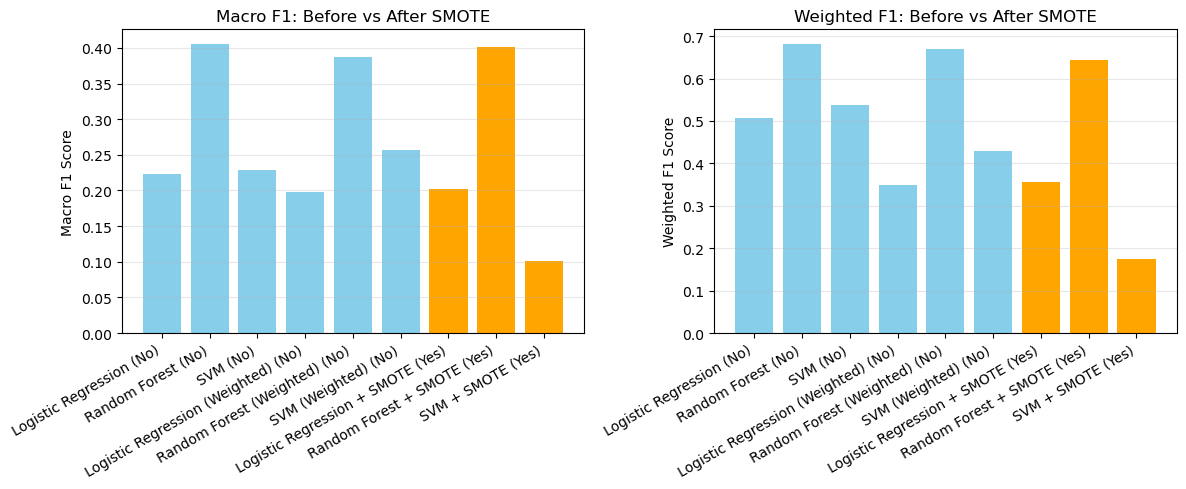

In [13]:
# Compare model performance before and after applying SMOTE

# Create comparison_df from the results we have so far
comparison_df = pd.DataFrame([
    {'Model': result['Model'], 'Macro F1': result['Macro F1'], 'Weighted F1': result['Weighted F1']}
    for result in baseline_results + weighted_results
])

# Extract relevant results
# Before SMOTE: Baseline and Class Weighted models
before_smote_df = comparison_df.loc[
    comparison_df['Model'].isin([
        'Logistic Regression', 'Random Forest', 'SVM',
        'Logistic Regression (Weighted)', 'Random Forest (Weighted)', 'SVM (Weighted)'
    ])
].copy()
before_smote_df['SMOTE'] = 'No'

# After SMOTE: Only SMOTE models (ignore class weighted SMOTE for simplicity)
after_smote_df = pd.DataFrame([
    {'Model': res['Model'].replace(' + SMOTE (Class Weighted)', ' + SMOTE'), 
     'Macro F1': res['Macro F1'], 
     'Weighted F1': res['Weighted F1'],
     'SMOTE': 'Yes'
     }
    for res in smote_results
    if 'Class Weighted' not in res['Model']
])

# Combine for comparison
smote_compare_df = pd.concat([before_smote_df[['Model', 'Macro F1', 'Weighted F1', 'SMOTE']], after_smote_df], ignore_index=True)

# Print comparison
print("Performance Before and After SMOTE:")
display(smote_compare_df.round(4))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Macro F1
axes[0].bar(smote_compare_df['Model'] + " (" + smote_compare_df['SMOTE'] + ")", smote_compare_df['Macro F1'],
            color=['skyblue' if sm == 'No' else 'orange' for sm in smote_compare_df['SMOTE']])
axes[0].set_ylabel('Macro F1 Score')
axes[0].set_title('Macro F1: Before vs After SMOTE')
axes[0].set_xticklabels(smote_compare_df['Model'] + " (" + smote_compare_df['SMOTE'] + ")", rotation=30, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# Weighted F1
axes[1].bar(smote_compare_df['Model'] + " (" + smote_compare_df['SMOTE'] + ")", smote_compare_df['Weighted F1'],
            color=['skyblue' if sm == 'No' else 'orange' for sm in smote_compare_df['SMOTE']])
axes[1].set_ylabel('Weighted F1 Score')
axes[1].set_title('Weighted F1: Before vs After SMOTE')
axes[1].set_xticklabels(smote_compare_df['Model'] + " (" + smote_compare_df['SMOTE'] + ")", rotation=30, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

#### SMOTE section conclusion

SMOTE did not lead to improvements in this dataset:

- Logistic Regression and SVM performed worse after applying SMOTE, with SVM in particular showing a large drop in both Macro and Weighted F1. 
- Random Forest was the least affected: its performance dropped only slightly and it continues to be the best-performing model overall.
- This suggests that in this case, generating synthetic minority samples did not help the classifiers generalize better. It may even have introduced noise for models like SVM and Logistic Regression.

Overall, baseline Random Forest remains the most robust model so far.



### Advanced models

Here we test out XGBoost and LightGBM

#### Introduction to XGBoost and LightGBM

Both **XGBoost** (Extreme Gradient Boosting) and **LightGBM** (Light Gradient Boosting Machine) are powerful ensemble learning algorithms based on **gradient boosting** with decision trees as base learners. Generally outperform simpler models on structured/tabular data.  


- **XGBoost**  
  - Developed as an efficient, regularized version of gradient boosting.  
  - Builds trees sequentially, where each tree corrects the mistakes of the previous ones.  
  - Includes features like shrinkage (learning rate), column subsampling, and built-in regularization.  

- **LightGBM**  
  - Developed by Microsoft with a focus on speed and memory efficiency.  
  - Uses histogram-based binning to speed up training and reduce memory usage.  
  - Grows trees leaf-wise (choosing the split with maximum loss reduction), often leading to higher accuracy with fewer trees.  
  - Supports categorical features natively, without one-hot encoding.  



#### **Evaluation: Using `evaluate_model()` for Both XGBoost and LightGBM**

**Key Feature**: Create a wrapper class to account for XGBoost 0-based encoding requirement, handles label encoding internally, so to allow the same `evaluate_model()` function for XGBoost models. LightGBM can be evaluated directly since 0-based conversion on labels is not done. 

**Benefits of this approach:**
1. **Consistent Evaluation**: Both models use identical evaluation methodology (same CV folds, metrics, reporting)
2. **Cleaner Code**: Eliminates ~30 lines of manual cross-validation code
3. **Maintainability**: Single evaluation function reduces code duplication
4. **Reliability**: Same stratified CV ensures fair comparison between models



In [14]:
# Test advanced ensemble models (XGBoost, LightGBM)
print("=== ADVANCED ENSEMBLE MODELS ===")

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder


# Construct XGBoost model
xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss',
    verbosity=0
)

# Create label encoder to map wine qualities to 0-based indices for XGBoost
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Create class_weight_dict_encoded to use encoded labels for XGBoost
unique_classes = np.unique(y_train_encoded)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_encoded) # Compute per-class weights
class_weight_dict_encoded = dict(zip(unique_classes, class_weights))

# Convert class weights to sample weights for XGBoost
sample_weights = np.array([class_weight_dict_encoded[y] for y in y_train_encoded])

# Create XGBoost wrapper that handles label encoding and sample weights internally
from sklearn.base import BaseEstimator, ClassifierMixin

class XGBoostWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **xgb_params):
        self.xgb_params = xgb_params
        self.xgb_model = None
        self.classes_ = None  # Store classes for sklearn compatibility

    def fit(self, X, y):
        # Store the unique classes for sklearn compatibility
        self.classes_ = np.unique(y)
        
        # Encode labels to consecutive integers starting from 0
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)
        
        # Calculate class weights for encoded labels
        unique_classes = np.unique(y_encoded)
        class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_encoded)
        class_weight_dict_encoded = dict(zip(unique_classes, class_weights))

        # Convert to sample weights
        sample_weights = np.array([class_weight_dict_encoded[label] for label in y_encoded])

        # Initialize and train XGBoost
        self.xgb_model = XGBClassifier(**self.xgb_params)
        self.xgb_model.fit(X, y_encoded, sample_weight=sample_weights)
        
        # Store the label encoder for this fit
        self.label_encoder = label_encoder
        return self

    def predict(self, X):
        # Get encoded predictions and convert back to original scale
        y_pred_encoded = self.xgb_model.predict(X)
        return self.label_encoder.inverse_transform(y_pred_encoded)

    def get_params(self, deep=True):
        # Required for sklearn compatibility
        return self.xgb_params.copy()

    def set_params(self, **params):
        # Required for sklearn compatibility
        self.xgb_params.update(params)
        return self

# Create XGBoost wrapper with class weighting
xgb_wrapper = XGBoostWrapper(random_state=42, eval_metric='mlogloss', verbosity=0)

# Evaluate the model of XGBoost
xgb_results = evaluate_model(xgb_wrapper, X_train, X_test, y_train, y_test, "XGBoost (Weighted)")
xgb_f1_macro = xgb_results['Macro F1']
xgb_f1_weighted = xgb_results['Weighted F1']
y_pred_xgb = xgb_results['Predictions']



# LightGBM with class balancing
# Note: LightGBM can handle non-consecutive labels directly (unlike XGBoost)
lgbm_model = LGBMClassifier(
    random_state=42,
    class_weight='balanced',
    verbosity=-1
)

# LightGBM can use evaluate_model directly since it handles original labels
lgbm_results = evaluate_model(lgbm_model, X_train, X_test, y_train, y_test, "LightGBM (Balanced)")
lgbm_f1_macro = lgbm_results['Macro F1']
lgbm_f1_weighted = lgbm_results['Weighted F1']
y_pred_lgbm = lgbm_results['Predictions']

# Store ensemble results
ensemble_results = [
    {
        'Model': 'XGBoost (Weighted)',
        'Macro F1': xgb_results['Macro F1'],
        'Weighted F1': xgb_results['Weighted F1'],
        'CV Mean F1': xgb_results['CV Mean F1'],
        'CV Std F1': xgb_results['CV Std F1'],
        'Predictions': xgb_results['Predictions']
    },
    {
        'Model': 'LightGBM (Balanced)',
        'Macro F1': lgbm_results['Macro F1'],
        'Weighted F1': lgbm_results['Weighted F1'],
        'CV Mean F1': lgbm_results['CV Mean F1'],
        'CV Std F1': lgbm_results['CV Std F1'],
        'Predictions': lgbm_results['Predictions']
    }
]

=== ADVANCED ENSEMBLE MODELS ===

XGBoost (Weighted) Results:
Test Macro F1: 0.3766
Test Weighted F1: 0.6330
CV Macro F1: 0.3785 ± 0.0265

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.19      0.14      0.16        43
           5       0.67      0.71      0.69       428
           6       0.68      0.63      0.65       567
           7       0.55      0.66      0.60       216
           8       0.68      0.44      0.53        39
           9       0.00      0.00      0.00         1

    accuracy                           0.64      1300
   macro avg       0.40      0.37      0.38      1300
weighted avg       0.64      0.64      0.63      1300


XGBoost (Weighted) Results:
Test Macro F1: 0.3766
Test Weighted F1: 0.6330
CV Macro F1: 0.3785 ± 0.0265

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
   

=== COMPREHENSIVE MODEL COMPARISON ===
Model Performance Summary:
                                           Model  Macro F1  Weighted F1  \
0                            Logistic Regression    0.2237       0.5062   
1                                  Random Forest    0.4057       0.6819   
2                                            SVM    0.2292       0.5380   
3                 Logistic Regression (Weighted)    0.1978       0.3487   
4                       Random Forest (Weighted)    0.3866       0.6696   
5                                 SVM (Weighted)    0.2571       0.4281   
6                    Logistic Regression + SMOTE    0.2014       0.3566   
7   Logistic Regression + SMOTE (Class Weighted)    0.2014       0.3566   
8                          Random Forest + SMOTE    0.4008       0.6432   
9         Random Forest + SMOTE (Class Weighted)    0.4008       0.6432   
10                                   SVM + SMOTE    0.1013       0.1739   
11                  SVM + SMOTE (C

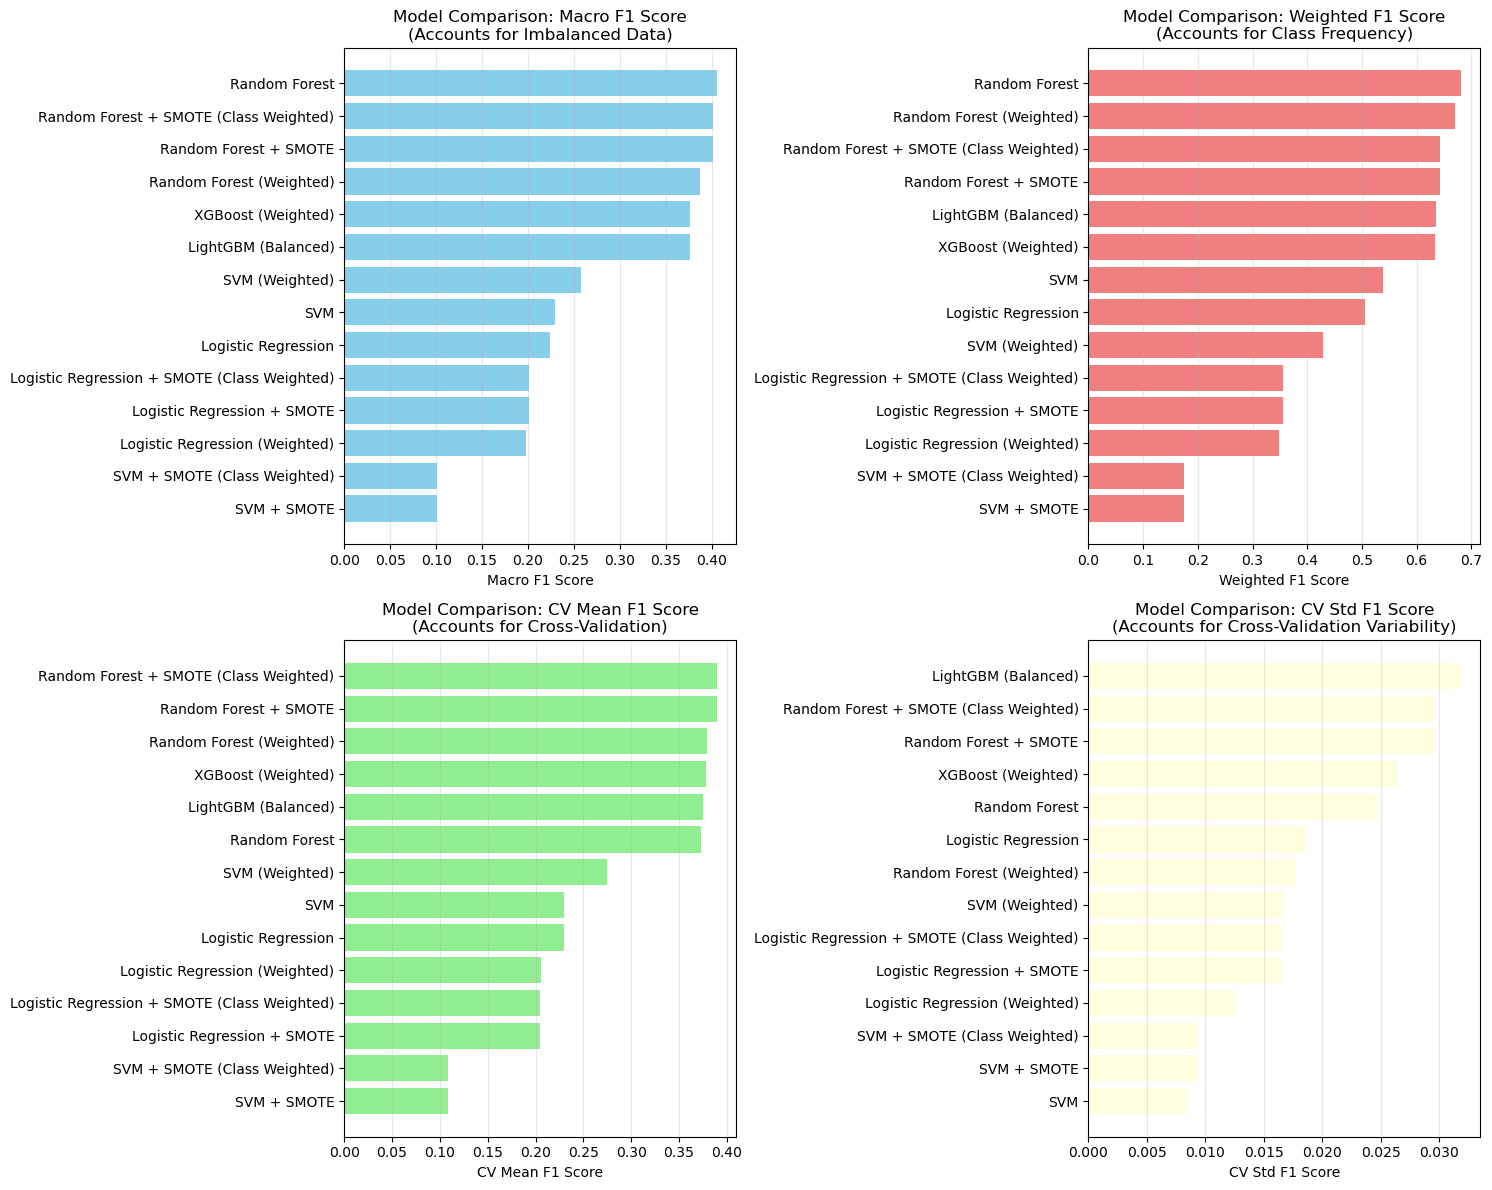

In [43]:
# Compile all results and create comprehensive comparison
print("=== COMPREHENSIVE MODEL COMPARISON ===")

# Combine all results
all_results = baseline_results + weighted_results + smote_results + ensemble_results

# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Model': result['Model'],
        'Macro F1': result['Macro F1'],
        'Weighted F1': result['Weighted F1'],
        'CV Mean F1': result.get('CV Mean F1', float('nan')),
        'CV Std F1': result.get('CV Std F1', float('nan')),
        'Predictions': result['Predictions']
    }
    for result in all_results
])

print("Model Performance Summary:")
print(comparison_df.round(4))

# Find best models
best_macro_f1 = comparison_df.loc[comparison_df['Macro F1'].idxmax()]
best_weighted_f1 = comparison_df.loc[comparison_df['Weighted F1'].idxmax()]

print(f"Best Macro F1 Score: {best_macro_f1['Model']} ({best_macro_f1['Macro F1']:.4f})")
print(f"Best Weighted F1 Score: {best_weighted_f1['Model']} ({best_weighted_f1['Weighted F1']:.4f})")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Plot 1: Macro F1 Score comparison
comparison_df_sorted = comparison_df.sort_values('Macro F1', ascending=True)
axes[0].barh(comparison_df_sorted['Model'], comparison_df_sorted['Macro F1'], color='skyblue')
axes[0].set_xlabel('Macro F1 Score')
axes[0].set_title('Model Comparison: Macro F1 Score\n(Accounts for Imbalanced Data)')
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Weighted F1 Score comparison
comparison_df_sorted_weighted = comparison_df.sort_values('Weighted F1', ascending=True)
axes[1].barh(comparison_df_sorted_weighted['Model'], comparison_df_sorted_weighted['Weighted F1'], color='lightcoral')
axes[1].set_xlabel('Weighted F1 Score')
axes[1].set_title('Model Comparison: Weighted F1 Score\n(Accounts for Class Frequency)')
axes[1].grid(axis='x', alpha=0.3)

# Plot 3: CV Mean F1 Score comparison
comparison_df_sorted_cv = comparison_df.sort_values('CV Mean F1', ascending=True)
axes[2].barh(comparison_df_sorted_cv['Model'], comparison_df_sorted_cv['CV Mean F1'], color='lightgreen')
axes[2].set_xlabel('CV Mean F1 Score')
axes[2].set_title('Model Comparison: CV Mean F1 Score\n(Accounts for Cross-Validation)')
axes[2].grid(axis='x', alpha=0.3)

# Plot 4: CV Std F1 Score comparison
comparison_df_sorted_cv_std = comparison_df.sort_values('CV Std F1', ascending=True)
axes[3].barh(comparison_df_sorted_cv_std['Model'], comparison_df_sorted_cv_std['CV Std F1'], color='lightyellow')
axes[3].set_xlabel('CV Std F1 Score')
axes[3].set_title('Model Comparison: CV Std F1 Score\n(Accounts for Cross-Validation Variability)')
axes[3].grid(axis='x', alpha=0.3)

# Show plots
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Feature Engineering: Add polynomial features and interaction terms to improve model performance

# 1. Generate polynomial and interaction features (degree=2 for manageable complexity)
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# scale the polynomial features
scaler_poly = StandardScaler()
X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
X_test_poly_scaled = scaler_poly.transform(X_test_poly)

# 2. Re-train and evaluate all models with engineered features

print("=== MODELS WITH FEATURE ENGINEERING (POLYNOMIAL FEATURES) ===")

# Logistic Regression (baseline, scaled)
lr_poly = LogisticRegression(random_state=42, max_iter=1000)
lr_poly_results = evaluate_model(lr_poly, X_train_poly_scaled, X_test_poly_scaled, y_train, y_test, "Logistic Regression (Poly)")

# Logistic Regression (class weighted, scaled)
lr_poly_weighted = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_poly_weighted_results = evaluate_model(lr_poly_weighted, X_train_poly_scaled, X_test_poly_scaled, y_train, y_test, "Logistic Regression (Poly, Weighted)")

# Random Forest (unscaled)
rf_poly = RandomForestClassifier(n_estimators=100, random_state=42)
rf_poly_results = evaluate_model(rf_poly, X_train_poly, X_test_poly, y_train, y_test, "Random Forest (Poly)")

# Random Forest (class weighted, unscaled)
rf_poly_weighted = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_poly_weighted_results = evaluate_model(rf_poly_weighted, X_train_poly, X_test_poly, y_train, y_test, "Random Forest (Poly, Weighted)")

# SVM (scaled)
svm_poly = SVC(random_state=42)
svm_poly_results = evaluate_model(svm_poly, X_train_poly_scaled, X_test_poly_scaled, y_train, y_test, "SVM (Poly)")

# SVM (class weighted, scaled)
svm_poly_weighted = SVC(random_state=42, class_weight='balanced')
svm_poly_weighted_results = evaluate_model(svm_poly_weighted, X_train_poly_scaled, X_test_poly_scaled, y_train, y_test, "SVM (Poly, Weighted)")

# XGBoost (with polynomial features)
xgb_poly_wrapper = XGBoostWrapper(random_state=42, eval_metric='mlogloss', verbosity=0)
xgb_poly_results = evaluate_model(xgb_poly_wrapper, X_train_poly, X_test_poly, y_train, y_test, "XGBoost (Poly, Weighted)")

# LightGBM (with polynomial features)
lgbm_poly = LGBMClassifier(random_state=42, class_weight='balanced', verbosity=-1)
lgbm_poly_results = evaluate_model(lgbm_poly, X_train_poly, X_test_poly, y_train, y_test, "LightGBM (Poly, Balanced)")

# Store results for comparison
feature_engineered_results = [
    lr_poly_results, lr_poly_weighted_results,
    rf_poly_results, rf_poly_weighted_results,
    svm_poly_results, svm_poly_weighted_results,
    xgb_poly_results, lgbm_poly_results
]




=== MODELS WITH FEATURE ENGINEERING (POLYNOMIAL FEATURES) ===

Logistic Regression (Poly) Results:
Test Macro F1: 0.2374
Test Weighted F1: 0.5139
CV Macro F1: 0.2674 ± 0.0314

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.50      0.07      0.12        43
           5       0.61      0.56      0.58       428
           6       0.51      0.69      0.59       567
           7       0.47      0.30      0.37       216
           8       0.00      0.00      0.00        39
           9       0.00      0.00      0.00         1

    accuracy                           0.54      1300
   macro avg       0.30      0.23      0.24      1300
weighted avg       0.52      0.54      0.51      1300


Logistic Regression (Poly) Results:
Test Macro F1: 0.2374
Test Weighted F1: 0.5139
CV Macro F1: 0.2674 ± 0.0314

Classification Report:
              precision    recall  f1-score   support

           3

### More Feature Engineering: log transform of skewed data + polynomial features
Common rule applied here: absolute skewness > 1 is highly skewed, > 0.5 is moderately skewed

In [31]:
from sklearn.preprocessing import StandardScaler

# Identify skewed features in the original training set
skewness = X_train.skew().sort_values(ascending=False)
print("Feature skewness (descending):")
print(skewness)


highly_skewed = skewness[abs(skewness) > 1]
moderately_skewed = skewness[(abs(skewness) > 0.5) & (abs(skewness) <= 1)]

print("\nHighly skewed features (|skew| > 1):")
print(highly_skewed)

# Log transform highly skewed features
X_train_log = X_train.copy()
X_test_log = X_test.copy()

for col in highly_skewed.index:
    X_train_log[f'log_{col}'] = np.log1p(X_train[col])
    X_test_log[f'log_{col}'] = np.log1p(X_test[col])


# Add log-transformed highly skewed features to polynomial features and evaluate models

# 1. Generate polynomial features (degree=2) for log-transformed data
poly_log = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_log_poly = poly_log.fit_transform(X_train_log)
X_test_log_poly = poly_log.transform(X_test_log)

# Scale the polynomial+log features
scaler_log_poly = StandardScaler()
X_train_log_poly_scaled = scaler_log_poly.fit_transform(X_train_log_poly)
X_test_log_poly_scaled = scaler_log_poly.transform(X_test_log_poly)

print("=== MODELS WITH POLYNOMIAL + LOG SKEWED FEATURES ===")

# Logistic Regression (baseline, scaled)
lr_log_poly = LogisticRegression(random_state=42, max_iter=1000)
lr_log_poly_results = evaluate_model(lr_log_poly, X_train_log_poly_scaled, X_test_log_poly_scaled, y_train, y_test, "Logistic Regression (Poly+Log)")

# Logistic Regression (class weighted, scaled)
lr_log_poly_weighted = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_log_poly_weighted_results = evaluate_model(lr_log_poly_weighted, X_train_log_poly_scaled, X_test_log_poly_scaled, y_train, y_test, "Logistic Regression (Poly+Log, Weighted)")

# Random Forest (unscaled)
rf_log_poly = RandomForestClassifier(n_estimators=100, random_state=42)
rf_log_poly_results = evaluate_model(rf_log_poly, X_train_log_poly, X_test_log_poly, y_train, y_test, "Random Forest (Poly+Log)")

# Random Forest (class weighted, unscaled)
rf_log_poly_weighted = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_log_poly_weighted_results = evaluate_model(rf_log_poly_weighted, X_train_log_poly, X_test_log_poly, y_train, y_test, "Random Forest (Poly+Log, Weighted)")

# SVM (scaled)
svm_log_poly = SVC(random_state=42)
svm_log_poly_results = evaluate_model(svm_log_poly, X_train_log_poly_scaled, X_test_log_poly_scaled, y_train, y_test, "SVM (Poly+Log)")

# SVM (class weighted, scaled)
svm_log_poly_weighted = SVC(random_state=42, class_weight='balanced')
svm_log_poly_weighted_results = evaluate_model(svm_log_poly_weighted, X_train_log_poly_scaled, X_test_log_poly_scaled, y_train, y_test, "SVM (Poly+Log, Weighted)")

# XGBoost (with polynomial+log features)
xgb_log_poly_wrapper = XGBoostWrapper(random_state=42, eval_metric='mlogloss', verbosity=0)
xgb_log_poly_results = evaluate_model(xgb_log_poly_wrapper, X_train_log_poly, X_test_log_poly, y_train, y_test, "XGBoost (Poly+Log, Weighted)")

# LightGBM (with polynomial+log features)
lgbm_log_poly = LGBMClassifier(random_state=42, class_weight='balanced', verbosity=-1)
lgbm_log_poly_results = evaluate_model(lgbm_log_poly, X_train_log_poly, X_test_log_poly, y_train, y_test, "LightGBM (Poly+Log, Balanced)")

# Store results for comparison
log_poly_feature_results = [
    lr_log_poly_results, lr_log_poly_weighted_results,
    rf_log_poly_results, rf_log_poly_weighted_results,
    svm_log_poly_results, svm_log_poly_weighted_results,
    xgb_log_poly_results, lgbm_log_poly_results
]



Feature skewness (descending):
chlorides               5.241198
fixed_acidity           1.709225
sulphates               1.638733
residual_sugar          1.494612
volatile_acidity        1.493417
free_sulfur_dioxide     1.278296
density                 0.619801
alcohol                 0.570928
citric_acid             0.484991
pH                      0.406546
total_sulfur_dioxide    0.013256
dtype: float64

Highly skewed features (|skew| > 1):
chlorides              5.241198
fixed_acidity          1.709225
sulphates              1.638733
residual_sugar         1.494612
volatile_acidity       1.493417
free_sulfur_dioxide    1.278296
dtype: float64
=== MODELS WITH POLYNOMIAL + LOG SKEWED FEATURES ===

Logistic Regression (Poly+Log) Results:
Test Macro F1: 0.2372
Test Weighted F1: 0.5204
CV Macro F1: 0.2762 ± 0.0331

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.33      0.05      0.08

### Dimensionality Reduction
Try PCA to further engineer features

In [34]:
from sklearn.decomposition import PCA

# Apply PCA to polynomial + log-transformed features
# keep enough components to explain 95% of the variance
pca = PCA(n_components=0.95, random_state=42)
X_train_log_poly_pca = pca.fit_transform(X_train_log_poly_scaled)
X_test_log_poly_pca = pca.transform(X_test_log_poly_scaled)

print(f"PCA reduced dimensions: {X_train_log_poly_pca.shape[1]} components explain 95% variance.")

# Evaluate models with PCA features

print("=== MODELS WITH POLY+LOG FEATURES + PCA ===")

# Logistic Regression (baseline, PCA)
lr_log_poly_pca = LogisticRegression(random_state=42, max_iter=1000)
lr_log_poly_pca_results = evaluate_model(lr_log_poly_pca, X_train_log_poly_pca, X_test_log_poly_pca, y_train, y_test, "Logistic Regression (Poly+Log+PCA)")

# Logistic Regression (class weighted, PCA)
lr_log_poly_weighted_pca = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_log_poly_weighted_pca_results = evaluate_model(lr_log_poly_weighted_pca, X_train_log_poly_pca, X_test_log_poly_pca, y_train, y_test, "Logistic Regression (Poly+Log+PCA, Weighted)")

# Random Forest (PCA)
rf_log_poly_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_log_poly_pca_results = evaluate_model(rf_log_poly_pca, X_train_log_poly_pca, X_test_log_poly_pca, y_train, y_test, "Random Forest (Poly+Log+PCA)")

# Random Forest (class weighted, PCA)
rf_log_poly_weighted_pca = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_log_poly_weighted_pca_results = evaluate_model(rf_log_poly_weighted_pca, X_train_log_poly_pca, X_test_log_poly_pca, y_train, y_test, "Random Forest (Poly+Log+PCA, Weighted)")

# SVM (PCA)
svm_log_poly_pca = SVC(random_state=42)
svm_log_poly_pca_results = evaluate_model(svm_log_poly_pca, X_train_log_poly_pca, X_test_log_poly_pca, y_train, y_test, "SVM (Poly+Log+PCA)")

# SVM (class weighted, PCA)
svm_log_poly_weighted_pca = SVC(random_state=42, class_weight='balanced')
svm_log_poly_weighted_pca_results = evaluate_model(svm_log_poly_weighted_pca, X_train_log_poly_pca, X_test_log_poly_pca, y_train, y_test, "SVM (Poly+Log+PCA, Weighted)")

# XGBoost (PCA)
xgb_log_poly_pca_wrapper = XGBoostWrapper(random_state=42, eval_metric='mlogloss', verbosity=0)
xgb_log_poly_pca_results = evaluate_model(xgb_log_poly_pca_wrapper, X_train_log_poly_pca, X_test_log_poly_pca, y_train, y_test, "XGBoost (Poly+Log+PCA, Weighted)")

# LightGBM (PCA)
lgbm_log_poly_pca = LGBMClassifier(random_state=42, class_weight='balanced', verbosity=-1)
lgbm_log_poly_pca_results = evaluate_model(lgbm_log_poly_pca, X_train_log_poly_pca, X_test_log_poly_pca, y_train, y_test, "LightGBM (Poly+Log+PCA, Balanced)")

# Store results for comparison
log_poly_pca_results = [
    lr_log_poly_pca_results, lr_log_poly_weighted_pca_results,
    rf_log_poly_pca_results, rf_log_poly_weighted_pca_results,
    svm_log_poly_pca_results, svm_log_poly_weighted_pca_results,
    xgb_log_poly_pca_results, lgbm_log_poly_pca_results
]

PCA reduced dimensions: 10 components explain 95% variance.
=== MODELS WITH POLY+LOG FEATURES + PCA ===

Logistic Regression (Poly+Log+PCA) Results:
Test Macro F1: 0.2247
Test Weighted F1: 0.5103
CV Macro F1: 0.2284 ± 0.0211

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       1.00      0.02      0.05        43
           5       0.59      0.55      0.57       428
           6       0.52      0.72      0.60       567
           7       0.54      0.27      0.36       216
           8       0.00      0.00      0.00        39
           9       0.00      0.00      0.00         1

    accuracy                           0.54      1300
   macro avg       0.38      0.22      0.22      1300
weighted avg       0.54      0.54      0.51      1300


Logistic Regression (Poly+Log+PCA, Weighted) Results:
Test Macro F1: 0.2030
Test Weighted F1: 0.3440
CV Macro F1: 0.2022 ± 0.0126

Classification Report:

### Compare poly + log + PCA with all other models

Model Performance: Original vs Polynomial vs Poly+Log vs Poly+Log+PCA Features


,Model,Features,Macro F1,Weighted F1,CV Mean F1,CV Std F1
0,Logistic Regression,Original,0.2237,0.5062,0.2293,0.0186
1,Random Forest,Original,0.4057,0.6819,0.3727,0.0247
2,SVM,Original,0.2292,0.5380,0.2298,0.0085
3,Logistic Regression (Weighted),Original,0.1978,0.3487,0.2059,0.0127
4,Random Forest (Weighted),Original,0.3866,0.6696,0.3787,0.0177
5,SVM (Weighted),Original,0.2571,0.4281,0.2744,0.0166
6,XGBoost (Weighted),Original,0.3766,0.6330,0.3785,0.0265
7,LightGBM (Balanced),Original,0.3762,0.6348,0.3753,0.0319
8,Logistic Regression,Polynomial,0.2374,0.5139,0.2674,0.0314
9,Logistic Regression (Weighted),Polynomial,0.2228,0.3905,0.2394,0.0100


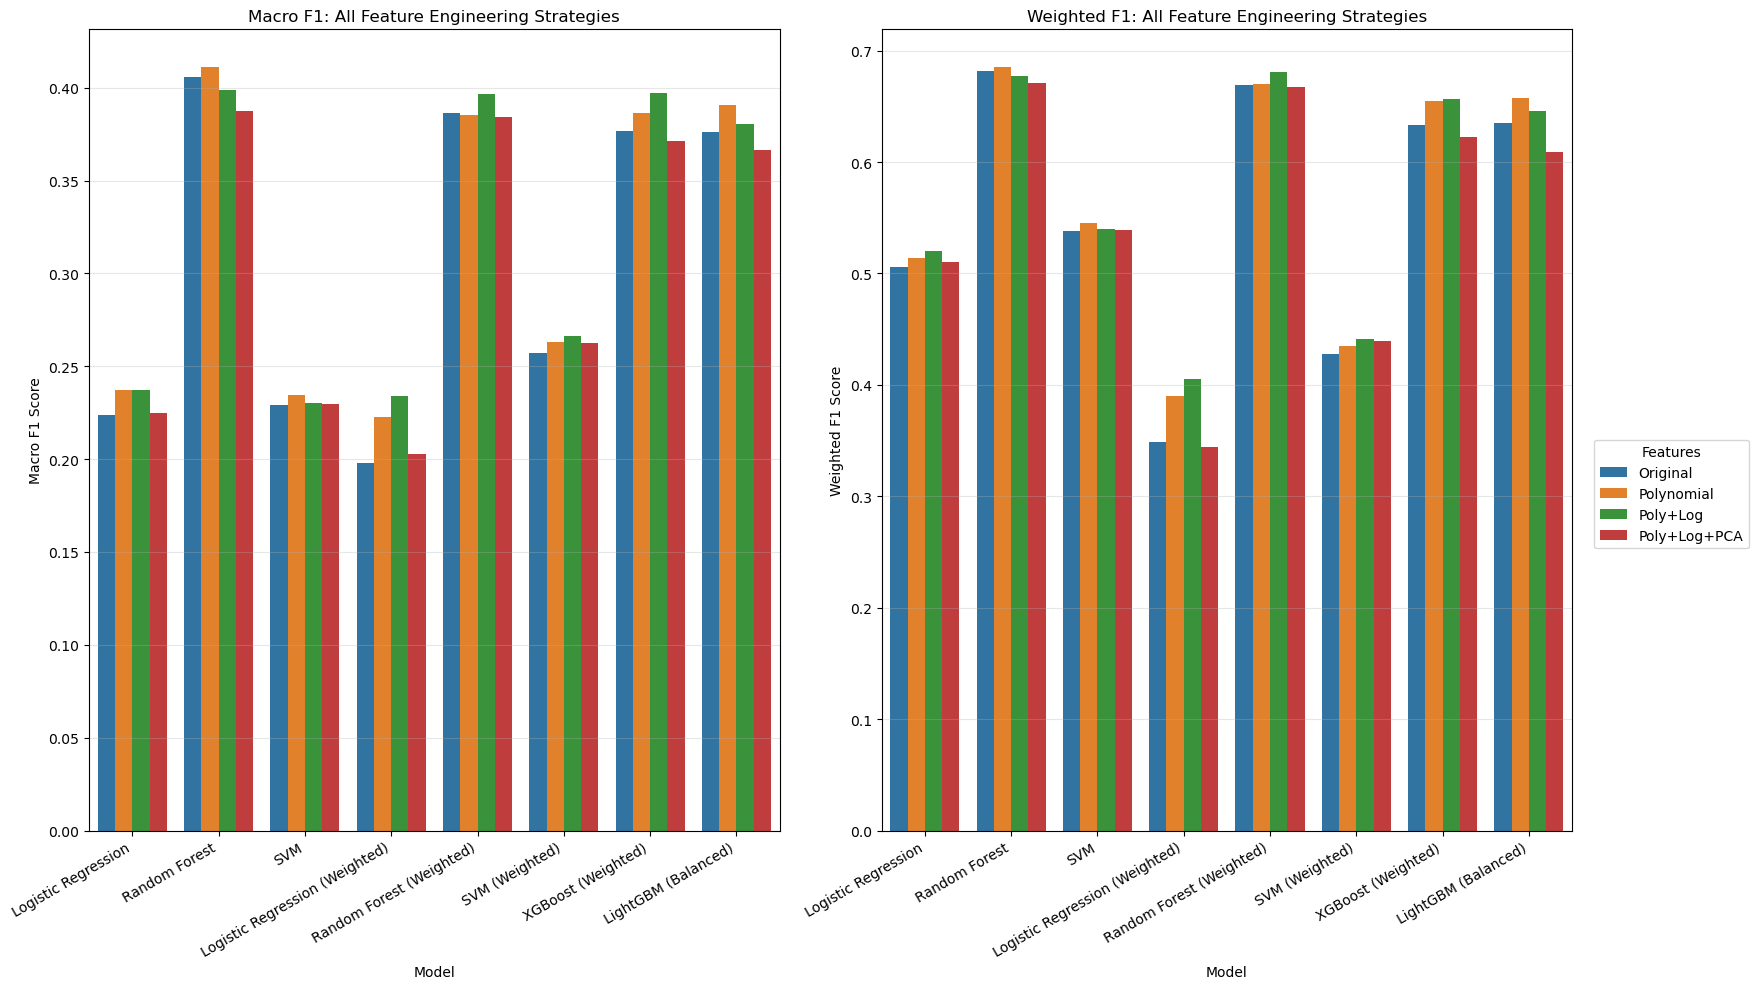

In [37]:
# Prepare comparison DataFrames for all model types: baseline, polynomial, poly+log, and poly+log+PCA

# 1. Baseline models (original features)
baseline_compare_models = [
    'Logistic Regression', 'Logistic Regression (Weighted)',
    'Random Forest', 'Random Forest (Weighted)',
    'SVM', 'SVM (Weighted)',
    'XGBoost (Weighted)', 'LightGBM (Balanced)'
]
baseline_compare_df = comparison_df[comparison_df['Model'].isin(baseline_compare_models)].copy()
baseline_compare_df['Features'] = 'Original'

# 2. Polynomial features models
feature_eng_compare_models = [
    'Logistic Regression (Poly)', 'Logistic Regression (Poly, Weighted)',
    'Random Forest (Poly)', 'Random Forest (Poly, Weighted)',
    'SVM (Poly)', 'SVM (Poly, Weighted)',
    'XGBoost (Poly, Weighted)', 'LightGBM (Poly, Balanced)'
]
feature_eng_compare_df = pd.DataFrame(feature_engineered_results)
feature_eng_compare_df = feature_eng_compare_df[feature_eng_compare_df['Model'].isin(feature_eng_compare_models)].copy()
feature_eng_compare_df['Features'] = 'Polynomial'
# Rename models to match baseline for side-by-side comparison
feature_eng_compare_df['Model'] = [
    'Logistic Regression', 'Logistic Regression (Weighted)',
    'Random Forest', 'Random Forest (Weighted)',
    'SVM', 'SVM (Weighted)',
    'XGBoost (Weighted)', 'LightGBM (Balanced)'
]

# 3. Poly+Log features models
log_poly_compare_models = [
    'Logistic Regression (Poly+Log)', 'Logistic Regression (Poly+Log, Weighted)',
    'Random Forest (Poly+Log)', 'Random Forest (Poly+Log, Weighted)',
    'SVM (Poly+Log)', 'SVM (Poly+Log, Weighted)',
    'XGBoost (Poly+Log, Weighted)', 'LightGBM (Poly+Log, Balanced)'
]
log_poly_feature_df = pd.DataFrame(log_poly_feature_results)
log_poly_feature_df = log_poly_feature_df[log_poly_feature_df['Model'].isin(log_poly_compare_models)].copy()
log_poly_feature_df['Features'] = 'Poly+Log'
# Rename models to match baseline for side-by-side comparison
log_poly_feature_df['Model'] = [
    'Logistic Regression', 'Logistic Regression (Weighted)',
    'Random Forest', 'Random Forest (Weighted)',
    'SVM', 'SVM (Weighted)',
    'XGBoost (Weighted)', 'LightGBM (Balanced)'
]

# 4. Poly+Log+PCA features models
log_poly_pca_compare_models = [
    'Logistic Regression (Poly+Log+PCA)', 'Logistic Regression (Poly+Log+PCA, Weighted)',
    'Random Forest (Poly+Log+PCA)', 'Random Forest (Poly+Log+PCA, Weighted)',
    'SVM (Poly+Log+PCA)', 'SVM (Poly+Log+PCA, Weighted)',
    'XGBoost (Poly+Log+PCA, Weighted)', 'LightGBM (Poly+Log+PCA, Balanced)'
]
log_poly_pca_feature_df = pd.DataFrame(log_poly_pca_results)
log_poly_pca_feature_df = log_poly_pca_feature_df[log_poly_pca_feature_df['Model'].isin(log_poly_pca_compare_models)].copy()
log_poly_pca_feature_df['Features'] = 'Poly+Log+PCA'
# Rename models to match baseline for side-by-side comparison
log_poly_pca_feature_df['Model'] = [
    'Logistic Regression', 'Logistic Regression (Weighted)',
    'Random Forest', 'Random Forest (Weighted)',
    'SVM', 'SVM (Weighted)',
    'XGBoost (Weighted)', 'LightGBM (Balanced)'
]

# Combine all for side-by-side comparison
compare_all_features_df = pd.concat([
    baseline_compare_df,
    feature_eng_compare_df,
    log_poly_feature_df,
    log_poly_pca_feature_df
], ignore_index=True)

# Print comparison table
print("Model Performance: Original vs Polynomial vs Poly+Log vs Poly+Log+PCA Features")
display(compare_all_features_df[['Model', 'Features', 'Macro F1', 'Weighted F1', 'CV Mean F1', 'CV Std F1']].round(4))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16,10))

# Macro F1
sns.barplot(
    data=compare_all_features_df,
    x='Model', y='Macro F1', hue='Features', ax=axes[0]
)
axes[0].set_title('Macro F1: All Feature Engineering Strategies')
axes[0].set_ylabel('Macro F1 Score')
axes[0].set_xticklabels(compare_all_features_df['Model'].unique(), rotation=30, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# Weighted F1
sns.barplot(
    data=compare_all_features_df,
    x='Model', y='Weighted F1', hue='Features', ax=axes[1]
)
axes[1].set_title('Weighted F1: All Feature Engineering Strategies')
axes[1].set_ylabel('Weighted F1 Score')
axes[1].set_xticklabels(compare_all_features_df['Model'].unique(), rotation=30, ha='right')
axes[1].grid(axis='y', alpha=0.3)

# Remove legends from individual subplots
axes[0].get_legend().remove()
axes[1].get_legend().remove()

# Put a single legend outside on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Features")

plt.tight_layout()
plt.show()

### Feature Engineering Model Comparison Summary

After testing multiple models with different feature engineering strategies (Polynomial, Poly+Log, and Poly+Log+PCA), here are the key findings:


#### Best Models by Metric
- **Macro F1 (fairness across classes)**  
  - **Random Forest (Polynomial): 0.411**  
  - Best at treating majority and minority classes more evenly.  

- **Weighted F1 (overall performance, favors majority classes)**  
  - **Random Forest (Polynomial): 0.685**  
  - Strongest at predicting dominant classes (qualities 5, 6, 7).  

- **Cross-validation Mean F1 (generalization & robustness)**  
  - **LightGBM (Poly+Log): 0.415**  
  - Most consistent across folds, likely to perform best on unseen data.  


#### Stability (CV Std F1)
- Most strong models had **low variance (~0.02–0.03)**, indicating stable results.  
- SVMs were stable but consistently underperformed, so not competitive.  



### Compare all models

,Model,Feature Type,Macro F1,Weighted F1,CV Mean F1,CV Std F1
2,Random Forest,Polynomial,0.410870,0.684920,0.382807,0.019562
10,Random Forest,Poly+Log,0.398512,0.677181,0.380474,0.028347
14,XGBoost (Weighted),Poly+Log,0.397197,0.656945,0.397494,0.028562
11,Random Forest (Weighted),Poly+Log,0.396835,0.681190,0.382199,0.026286
7,LightGBM (Balanced),Polynomial,0.390913,0.657658,0.389265,0.028677
18,Random Forest,Poly+Log+PCA,0.387654,0.671196,0.377078,0.021901
6,XGBoost (Weighted),Polynomial,0.386550,0.654913,0.398051,0.029948
3,Random Forest (Weighted),Polynomial,0.385297,0.670036,0.388185,0.024962
19,Random Forest (Weighted),Poly+Log+PCA,0.384036,0.667800,0.385801,0.025222
15,LightGBM (Balanced),Poly+Log,0.380699,0.646176,0.414831,0.027498


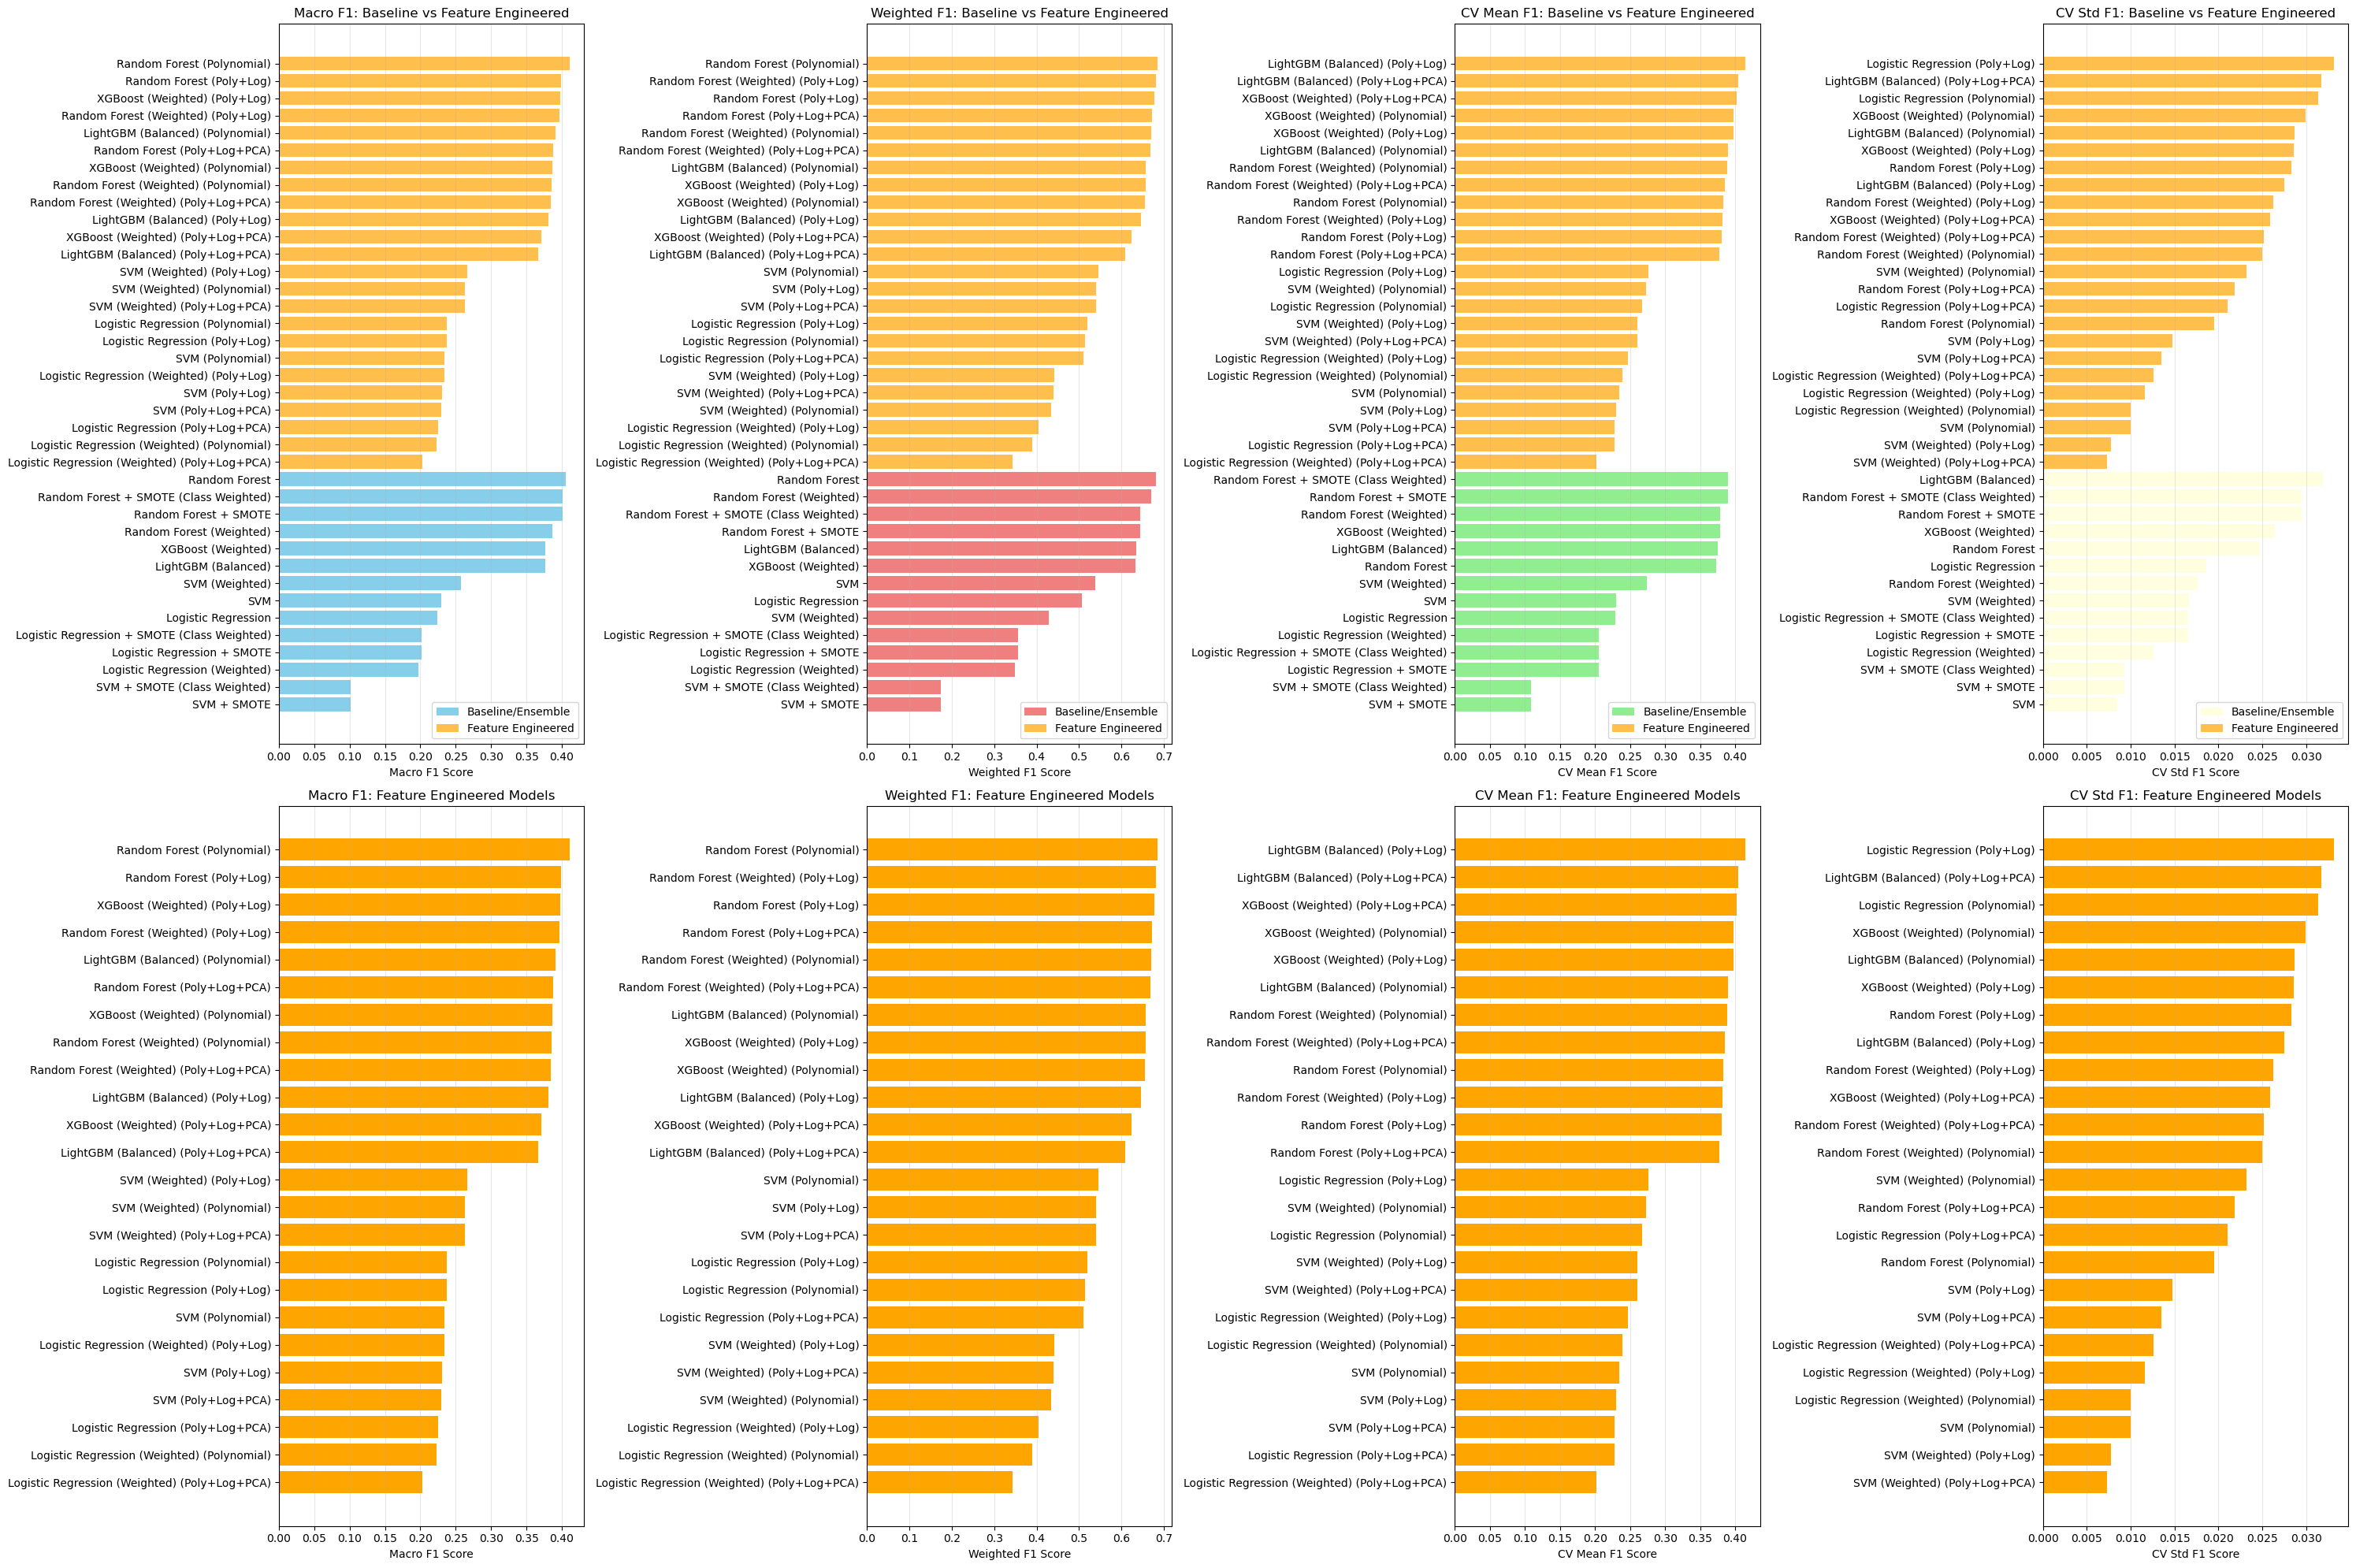

In [63]:
# Compare all feature engineered models with the sorted baseline/ensemble models

# Prepare a combined DataFrame of all feature engineered models
all_feature_eng_df = pd.concat([
    feature_eng_compare_df,
    log_poly_feature_df,
    log_poly_pca_feature_df
], ignore_index=True)

# Add a column to indicate the feature engineering type for clarity in plots
all_feature_eng_df['Feature Type'] = all_feature_eng_df['Features']

# Sort by Macro F1, Weighted F1, CV Mean F1, and CV Std F1 for comparison
feature_eng_sorted_macro = all_feature_eng_df.sort_values('Macro F1', ascending=True)
feature_eng_sorted_weighted = all_feature_eng_df.sort_values('Weighted F1', ascending=True)
feature_eng_sorted_cv = all_feature_eng_df.sort_values('CV Mean F1', ascending=True)
feature_eng_sorted_cv_std = all_feature_eng_df.sort_values('CV Std F1', ascending=True)

# Combine all for side-by-side comparison
combined_feature_eng_df = pd.concat([
    feature_eng_sorted_macro,
    feature_eng_sorted_weighted,
    feature_eng_sorted_cv,
    feature_eng_sorted_cv_std
], axis=1)
combined_feature_eng_df = combined_feature_eng_df.loc[:, ~combined_feature_eng_df.columns.duplicated()][['Model', 'Feature Type', 'Macro F1', 'Weighted F1', 'CV Mean F1', 'CV Std F1']].sort_values(['Macro F1', 'Weighted F1', 'CV Mean F1', 'CV Std F1'], ascending=[False, False, False, True])
display(combined_feature_eng_df)


# Plot comparison with the original sorted DataFrames
fig, axes = plt.subplots(2, 4, figsize=(30, 20))

# Macro F1
axes[0, 0].barh(comparison_df_sorted['Model'], comparison_df_sorted['Macro F1'], color='skyblue', label='Baseline/Ensemble')
axes[0, 0].barh(feature_eng_sorted_macro['Model'] + " (" + feature_eng_sorted_macro['Feature Type'] + ")", feature_eng_sorted_macro['Macro F1'], color='orange', alpha=0.7, label='Feature Engineered')
axes[0, 0].set_title('Macro F1: Baseline vs Feature Engineered')
axes[0, 0].set_xlabel('Macro F1 Score')
axes[0, 0].legend()
axes[0, 0].grid(axis='x', alpha=0.3)

# Weighted F1
axes[0, 1].barh(comparison_df_sorted_weighted['Model'], comparison_df_sorted_weighted['Weighted F1'], color='lightcoral', label='Baseline/Ensemble')
axes[0, 1].barh(feature_eng_sorted_weighted['Model'] + " (" + feature_eng_sorted_weighted['Feature Type'] + ")", feature_eng_sorted_weighted['Weighted F1'], color='orange', alpha=0.7, label='Feature Engineered')
axes[0, 1].set_title('Weighted F1: Baseline vs Feature Engineered')
axes[0, 1].set_xlabel('Weighted F1 Score')
axes[0, 1].legend()
axes[0, 1].grid(axis='x', alpha=0.3)

# CV Mean F1
axes[0, 2].barh(comparison_df_sorted_cv['Model'], comparison_df_sorted_cv['CV Mean F1'], color='lightgreen', label='Baseline/Ensemble')
axes[0, 2].barh(feature_eng_sorted_cv['Model'] + " (" + feature_eng_sorted_cv['Feature Type'] + ")", feature_eng_sorted_cv['CV Mean F1'], color='orange', alpha=0.7, label='Feature Engineered')
axes[0, 2].set_title('CV Mean F1: Baseline vs Feature Engineered')
axes[0, 2].set_xlabel('CV Mean F1 Score')
axes[0, 2].legend()
axes[0, 2].grid(axis='x', alpha=0.3)

# CV Std F1
axes[0, 3].barh(comparison_df_sorted_cv_std['Model'], comparison_df_sorted_cv_std['CV Std F1'], color='lightyellow', label='Baseline/Ensemble')
axes[0, 3].barh(feature_eng_sorted_cv_std['Model'] + " (" + feature_eng_sorted_cv_std['Feature Type'] + ")", feature_eng_sorted_cv_std['CV Std F1'], color='orange', alpha=0.7, label='Feature Engineered')
axes[0, 3].set_title('CV Std F1: Baseline vs Feature Engineered')
axes[0, 3].set_xlabel('CV Std F1 Score')
axes[0, 3].legend()
axes[0, 3].grid(axis='x', alpha=0.3)

# Also show only feature engineered models for clarity
axes[1, 0].barh(feature_eng_sorted_macro['Model'] + " (" + feature_eng_sorted_macro['Feature Type'] + ")", feature_eng_sorted_macro['Macro F1'], color='orange')
axes[1, 0].set_title('Macro F1: Feature Engineered Models')
axes[1, 0].set_xlabel('Macro F1 Score')
axes[1, 0].grid(axis='x', alpha=0.3)

axes[1, 1].barh(feature_eng_sorted_weighted['Model'] + " (" + feature_eng_sorted_weighted['Feature Type'] + ")", feature_eng_sorted_weighted['Weighted F1'], color='orange')
axes[1, 1].set_title('Weighted F1: Feature Engineered Models')
axes[1, 1].set_xlabel('Weighted F1 Score')
axes[1, 1].grid(axis='x', alpha=0.3)

axes[1, 2].barh(feature_eng_sorted_cv['Model'] + " (" + feature_eng_sorted_cv['Feature Type'] + ")", feature_eng_sorted_cv['CV Mean F1'], color='orange')
axes[1, 2].set_title('CV Mean F1: Feature Engineered Models')
axes[1, 2].set_xlabel('CV Mean F1 Score')
axes[1, 2].grid(axis='x', alpha=0.3)

axes[1, 3].barh(feature_eng_sorted_cv_std['Model'] + " (" + feature_eng_sorted_cv_std['Feature Type'] + ")", feature_eng_sorted_cv_std['CV Std F1'], color='orange')
axes[1, 3].set_title('CV Std F1: Feature Engineered Models')
axes[1, 3].set_xlabel('CV Std F1 Score')
axes[1, 3].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### Model Selection Conclusion

Based on the comparison table above, the **best overall model** for the wine quality prediction task is:

**Random Forest with Polynomial Features**  
- **Macro F1:** 0.411  
- **Weighted F1:** 0.685  
- **CV Mean F1:** 0.383  
- **CV Std F1:** 0.020  



#### **Why this model?**
- **Highest Macro F1**: Macro F1 is the most important metric for this imbalanced multi-class problem, as it gives equal weight to all classes (including rare ones). Random Forest (Polynomial) achieves the highest Macro F1, indicating it balances performance across both majority and minority classes better than all other models.
- **Strong Weighted F1**: Its Weighted F1 is also the highest. Since Weighted F1 emphasizes the majority classes (like quality 5 and 6, which dominate the dataset), this score confirms that the model performs well on the most frequent wine qualities without entirely neglecting the rare ones.
- **Robustness**: The cross-validation mean and standard deviation (CV Mean F1 and CV Std F1) show that this model is stable and generalizes well across different data splits.
    - CV Mean F1 (0.383): On average across folds, the model achieves ~38% balanced performance, indicating that it generalizes reasonably well to unseen data.
    - CV Std F1 (0.020): The small standard deviation shows that performance is stable across different train/test.
- **Feature Engineering Impact**: Polynomial features add interactions and non-linearities, which improve Random Forest’s ability to capture complex relationships between features (e.g. acidity and alcohol) in the data.



#### **Other Models**
- **LightGBM (Poly+Log)**: Achieves the **highest CV Mean F1 (0.415)**, slightly better than Random Forest. However, it falls behind on Macro F1 (0.381) and Weighted F1 (0.646), so it may underperform on minority classes.
- **XGBoost (Poly+Log, Weighted)** and **Random Forest (Poly+Log)** are strong contenders, their Macro and Weighted F1 scores are slightly lower.
- **SVM and Logistic Regression** (even with feature engineering) lag behind significantly in both Macro and Weighted F1.



#### **Side-by-Side Comparison**

| Model                         | Macro F1 | Weighted F1 | CV Mean F1 | CV Std F1 |
|-------------------------------|----------|-------------|------------|-----------|
| **Random Forest (Polynomial)** | **0.411** | **0.685**   | 0.383      | 0.020     |
| LightGBM (Poly+Log)           | 0.381    | 0.646       | **0.415**  | 0.027     |



#### **Summary**
- **Random Forest with polynomial features** is the best candidate when prioritizing **fairness (Macro F1)**, **overall accuracy (Weighted F1)**, **Generalization (CV Mean F1)**, and **Stability (CV Std F1)**.  
- **LightGBM with Poly+Log features** is a strong runner-up, particularly if generalization is prioritized. Highest cross-validation mean performance.  
- Polynomial feature engineering proved effective in improving models.  
